# Speedrunning Model Training
(includes `pytorch-lightning`!!)  

More often than not, you'll want to train your models as soon as possible. Maybe you're in a competition, or you're testing an architecture preliminarily, or maybe you're just really lazy. So, how can we squeeze the most time out of what we have?  

This is a list of techniques to use, one by one, to see how much we can improve training time by. We evalutate our techniques by training ResNet18 from scratch on CIFAR-10 for 10 epochs.  

Much of the techniques below were taken from the sources below:  
https://www.reddit.com/r/MachineLearning/comments/kvs1ex/d_here_are_17_ways_of_making_pytorch_training/  
https://lightning.ai/pages/community/tutorial/how-to-speed-up-pytorch-model-training/

In [1]:
import torch
import torch.nn as nn
import torchvision

### The Baseline
Here, we just import CIFAR-10 and apply some augmentations. Nothing special!  

In [2]:
from torchvision.transforms import v2

In [3]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((32, 32)),
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((32, 32)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])


train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=test_transforms)

In [4]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

As mentioned above, we use ResNet18. TorchVision provides the architecture for us, and in this case, we do not load any pretrained weights as we want to train it from scratch.

In [5]:
from torchvision.models import resnet18

In [6]:
model = resnet18()

I'm gonna use PyTorch Lightning because, well, I'm a lazy person - and it's addictive how lazy you can get using Lightning. Just plug in your module and let the framework handle the training for you!

In [7]:
import pytorch_lightning as pl
import torchmetrics

In [8]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)

model = LResNet(resnet18, 3e-4)

Above I set the learning rate to `3e-4` - which is safe for most models using Adam-based optimizers. Reference https://karpathy.github.io/2019/04/25/recipe/ for more tricks like this!  

In [9]:
%%time
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 37s, sys: 4.93 s, total: 1min 42s
Wall time: 1min 39s


On this RTX 5060Ti that I'm renting, I get ~160it/s, and training the entire thing takes 1m 38s.  
*(You can expand the cell above to see the outputs. I'll be hiding a lot of outputs and cell contents which I deem not useful, but you can read them if you'd like!)*  

Let's see our accuracy...

In [10]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7633000016212463     │
│         val_loss          │     0.680317759513855     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.680317759513855, 'val_acc': 0.7633000016212463}]

Wow, 76%! That's honestly really good, and will be hard to beat.  

With that, let's start with how to make the model train faster.

### Method -1: Listen to Lightning

It's called -1 because you don't really do anything. Lightning complains that a setting isn't set properly, and most of the time its best to just follow.

In [9]:
torch.set_float32_matmul_precision('high')

Gonna do a quick test of the speed to test it now...

In [12]:
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


It's about 3it/s faster, just by listening to the framework!

### Method 0: Initialize Properly
I'm not stalling for time - this is something we *should* have done, but didn't! It can make surprising differences to the performance of the model.  

There's a lot of initialization methods out there, but a short summary is:
- Use **Kaiming initialization** when using non-symmetric ReLU-based activations,
- Use **Xavier initialization** when using symmetric activation functions like Tanh/Sigmoid, or no activation, and
- Use **Truncated Normal initialization** when using modern activations like GeLU.

Since we're using a ResNet, which uses ReLU activations, we use Kaiming initialization for the Conv2d weights. However, our classifier outputs raw logits (and by right is passed to a sigmoid function in cross entropy!) so we use Xavier initialization.

You may notice the `mode="fan_out"` argument when using Kaiming initialization. To briefly explain what it does:
- `fan_in` preserves the variance of the activations in the *forward pass*.
- `fan_out` preserves the variance of the gradients in the *backwards pass*.
- It's best to choose `fan_out` for deep, stacked layers like Conv2d in ResNet, and only use `fan_in` for shallow networks, or unconventional networks prone to exploding/vanishing gradients.

All biases are initialized to zero, and BatchNorm layers (as per all normalization layers) should have their weights set to one and bias to zero.

In [10]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)
        
        ###################################################################################################################
        # NEW! Apply the weight initialization function. You can look at the torch docs for the .apply method to know more.
        self.apply(self._init_weights)
        nn.init.xavier_uniform_(self.resnet.fc.weight)
        nn.init.zeros_(self.resnet.fc.bias)
        ###################################################################################################################

    #######################################################################################################################
    # NEW! The initialization function itself. The markdown block above should have explained the reasoning it well enough.
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu", mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    #######################################################################################################################

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)

Let's run the model and see how it performs now.

In [14]:
%%time
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 37s, sys: 4.93 s, total: 1min 42s
Wall time: 1min 39s


In [15]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7577000260353088     │
│         val_loss          │    0.7093212008476257     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7093212008476257, 'val_acc': 0.7577000260353088}]

The accuracy dropped a bit - but given between the first run and this had zero architectural or training changes, I'd say this is within the margin of error.  

*(NOTE: Our worsened accuracy is also because TorchVision itself has proper initialization techniques, some of which we missed here. However, I'm defining the initialization here for educational purposes, so we live with slightly worse accuracy for now.)*

### Method 1: Increase Batch Size

Maxing out the batch size is age-old advice. However, you **must** consider several factors.
1. The higher your batch size, the lower your accuracy. In settings where you want to maximize the accuracy, massively large batch sizes (>1024 is a safe estimate) will *significantly* tank your accuracy.
2. Make sure that you have enough batches left in your dataset. It's tempting to push for huge batch sizes as in research, but keep in mind that we're working with different amounts of data. They have, at least in ImageNet, *millions* of images. We have 50,000 in CIFAR.

I've devised a method, illustrated below, to find an ideal batch size in a time-constrained scenario. We can use the `max_time` parameter of Lightning's trainer to test how much the model learns in 1 minute.  

First, let's test the original batch size of 32 under these constraints.

In [16]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [17]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7315999865531921     │
│         val_loss          │    0.7828781604766846     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7828781604766846, 'val_acc': 0.7315999865531921}]

73%... a big step down. This is a sign that the batch size is too low, leading to inefficient use of the GPU.

Let's start with 128, or four times the initial value of 32.

In [18]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [19]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7544000148773193     │
│         val_loss          │    0.7640776634216309     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7640776634216309, 'val_acc': 0.7544000148773193}]

Almost even better than 32! This shows that we're using the GPU more efficiently.

Onwards to 512, four times 128.

In [20]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [21]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7024000287055969     │
│         val_loss          │    0.9209242463111877     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9209242463111877, 'val_acc': 0.7024000287055969}]

Now that's far below our best score so far - which we can't accept, as it will take a lot of tuning to get it back to where we want it.  

In the spirit of binary search, let's find a value in between that works. We start with 256, the number between 128 and 512.

In [22]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [23]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7039999961853027     │
│         val_loss          │    0.9127117395401001     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9127117395401001, 'val_acc': 0.7039999961853027}]

Barely better than 512, but 128 is still a better trade-off. Let's try 64 to see if it offers a better balance.

In [24]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [25]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7560999989509583     │
│         val_loss          │    0.7180350422859192     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7180350422859192, 'val_acc': 0.7560999989509583}]

Compared to 128, the loss is a lot lower! The accuracy is also slightly higher, although it's definitely within the margin of error.  

We'll proceed with this batch size for the rest of the notebook.

#### Optimizing Dataloaders for Performance

Let's time how long it takes to get one item from the Dataloader.

In [13]:
%%timeit
len(next(iter(train_loader))[0])

74.9 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Interestingly, we can optimize this further! I'll explain the important hyperparameters for PyTorch's `DataLoader` below:
- `num_workers`: The number of threads to spawn for loading the data. Note that Python is pretty finnicky about multiprocessing, so if you ever run into deadlocks (i.e. training hangs) try reducing this value, reducing the number of logging/print statements, or simply waiting a bit longer.
- `pin_memory`: Keeps the data pinned in memory. Sometimes this works for me, other times it seems that the data isn't pinned or I keep getting OOM errors. The general advice is to keep this enabled unless you really cannot.
- `prefetch_factor`: For each worker/thread, it will try to prep `prefetch_factor` batches of data the moment the DataLoader is initialized. Then, every time a batch is consumed by the model, it will try to once prep batches up to the indicated size. Try to keep `num_workers * prefetch_factor` less than your total number of batches, or you'll be wasting effort. Mostly applicable for massive batch sizes.
- `persistent_workers`: If true, PyTorch will reuse threads and not create new ones each epoch. This is good if you notice that at the start of each epoch, it takes a long time to load the first batch (since creating a thread takes time) and is more useful when you have massive batch sizes.

In [10]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=3, prefetch_factor=1, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=3, prefetch_factor=1, persistent_workers=True)

In [15]:
%%timeit
len(next(iter(train_loader))[0])

33.8 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


*2x* speed improvement! This may not be much, but it'll add up.

### Method 2: Find a better Learning Rate
With a larger batch size, the model gets more accurate and less noisy gradients. After all, surely the average gradient provided by double the samples is better than just 32. The issue is that if we don't capitalize on this more accurate gradient, all the effort will be put to waste.  

Thus, a larger learning rate is what best makes use of this gradient. Instead of taking many small and noisy steps, we take bigger and more accurate steps towards the minima.  

Classical literature suggests that when you increase the batch size by K times, you increase the learning rate by sqrt(K) times. Since we have the computing resources, let's test the hypothesis out.

In [16]:
%%time
model = LResNet(resnet18, 3e-4*(2**0.5))
trainer = pl.Trainer(max_time="00:00:01:00", log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

CPU times: user 1min, sys: 2.83 s, total: 1min 3s
Wall time: 1min 1s


In [17]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7473999857902527     │
│         val_loss          │     0.762093186378479     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.762093186378479, 'val_acc': 0.7473999857902527}]

That's not too bad - within the margin of error! However, when you're scaling to much larger batch sizes, the scaling rule starts breaking down.

If only there was a way for us to automatically find a proper learning rate...

#### Lightning's `Tuner` for `lr_find`
Turns out, Lightning provides a `Tuner` class to help us find an optimal learning rate! The internal mechanisms for how it decides so is buried within piles of research (search up Leslie N. Smith, he has a lot of good papers on this topic!) so let's just start by using it.  

The `lr_find` function basically increases the learning rate slowly and records the loss for each of the values. It does this for `num_training` steps - which we manually define as the default of 100 steps is a bit too low..

In [28]:
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
tuner = pl.tuner.Tuner(trainer)
results = tuner.lr_find(model, train_loader, test_loader, num_training=250)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=250` reached.
Learning rate set to 0.00016749428760264381
Restoring states from the checkpoint path at /workspace/CremeBrulee/General Skills/.lr_find_e83ed799-0995-401a-87ab-77cf273acbfe.ckpt
Restored all states from the checkpoint at /workspace/CremeBrulee/General Skills/.lr_find_e83ed799-0995-401a-87ab-77cf273acbfe.ckpt


We can plot the result of the learning rate sweep and the recommended value. Note that Lightning automatically modifies the model to use the recommended learning rate, so we won't have to bother more!

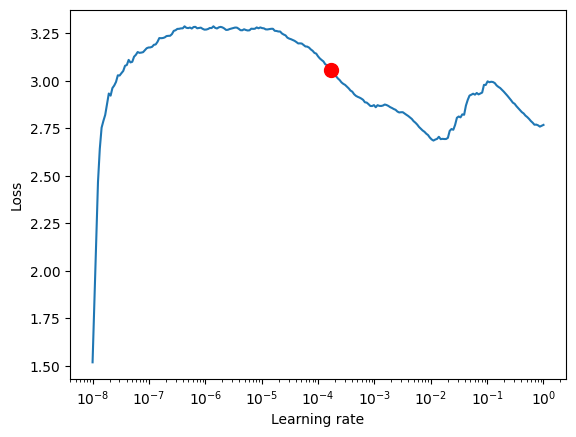

0.00016749428760264381

In [29]:
results.plot(suggest=True, show=True)
results.suggestion()

We see that the loss starts to decrease around 2e-5, plateaus a bit around 3e-4, and spikes up around 5e-3. The model suggests somewhere in between, around the value of 1e-4. We can term the 2e-5 LR the *min LR*, and the 5e-3 *max LR*.

These values will come in handy later. For now, let's just train the model with the recommended learning rate.

In [30]:
%%time
trainer.fit(model, train_loader, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


CPU times: user 59.1 s, sys: 2.63 s, total: 1min 1s
Wall time: 1min


In [31]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7251999974250793     │
│         val_loss          │    0.8127257227897644     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8127257227897644, 'val_acc': 0.7251999974250793}]

We can see that it's not the best - however, we must remember that we're working based on an algorithm. As humans, smart ones at best, we can do this thing called 'reading research papers'.  

And the *original* research papers and repositories implementing this learning rate finder suggest the value in between the min LR and max LR. In our case that number is...  

3e-4. Which means our original LR was already optimal. 

But wait - we're not done tuning the learning rate yet! Onwards to...

### Method 3: Using a Learning Rate Scheduler
We *should* be able to match 78% in this section.

In [12]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr, epochs):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        #############################################################################
        # NEW! Accept epochs, max_lr and min_lr, to make configuring OneCycleLR less painful.
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epochs = epochs
        #############################################################################

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)
        
        self.apply(self._init_weights)
        nn.init.xavier_uniform_(self.resnet.fc.weight)
        nn.init.zeros_(self.resnet.fc.bias)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu", mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        #######################################
        # NEW! Use OneCycleLR as the scheduler.
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=self.epochs, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]
        #######################################

In [35]:
%%time
model = LResNet(resnet18, 5e-3, 2e-5, 8)
trainer = pl.Trainer(max_epochs=8, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


CPU times: user 52.8 s, sys: 2.28 s, total: 55.1 s
Wall time: 53.2 s


In [36]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7960000038146973     │
│         val_loss          │    0.6065759062767029     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6065759062767029, 'val_acc': 0.7960000038146973}]

### Method 4: Mixed Precision Training

Mixed precision is almost like magic. When used properly, it's able to accelerate training, while keeping about the same accuracy!  

It does this by different precisions during different calculations. So, instead of operating on one 32-bit float, you can operate on two 16-bit floats! In reality there are some inefficiencies, but the gist of it is accurate - and the scale of improvement is too! In appropriately sized models, you are able to see the 2x speedup.

In Lightning, all we need to do is to pass the `precision` argument to the trainer. In this case, we use `bf16-mixed`, where:
- `bf16`: A type of half-precision (16-bit) float. Normal floats (`fp64`, `fp32`, `fp16`, `fp8`) give higher precision but lower range. Meanwhile, `bf16` has lower precision and higher range, which is greatly preferred in machine learning.. Search online if you want to know more!
- `mixed`: Mixed precision, where the calculations and backpropagation is done using `bf16` while the weights remain in full 32-bit accuracy. This is in comparison to `true`, where the weights are cast to `bf16` too.

In [14]:
%%time
model = LResNet(resnet18, 5e-3, 2e-5, 10)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=10, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 1s, sys: 2.72 s, total: 1min 4s
Wall time: 1min 2s


Our model is a bit small, but the speed increases such that we can increase our training by *two whole epochs* while still taking 1 minute!

In [15]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7968000173568726     │
│         val_loss          │    0.5918164849281311     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5918164849281311, 'val_acc': 0.7968000173568726}]

We see a slight improvement! We can see how the loss decreases slightly from the previous.  

As mentioned above, this technique is more useful in much larger, multi-million parameter models. In those models, you can even see up to a *5x* speedup!

### Method 5: Tuning Regularization
This isn't as general a technique as the ones above, but it's an important one to cover since we're optimizing for accuracy in the shortest amount of time.  

Regularization plays a key role in model performance, making sure that it doesn't overfit too quickly. However, too much can impede performance, and too little degrades performance too!  

#### Label Smoothing
Label smoothing is a *somewhat* general technique that can be used across all classification tasks. It shifts the distribution of your targets, such that instead of a one-hot vector like `[0, 1, 0]`, some of the probability is spread among the non-target values, i.e. `[0.05, 0.9, 0.05]`.  

How much it spreads is a hyperparameter of its own, but normally a value of `0.05` or `0.1` is used. I use `0.1` below. Note that PyTorch has label smoothing as part of its loss methods, so in our case the `cross_entropy` function.

In [34]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr, epochs):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epochs = epochs

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)
        
        self.apply(self._init_weights)
        nn.init.xavier_uniform_(self.resnet.fc.weight)
        nn.init.zeros_(self.resnet.fc.bias)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu", mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        ###########################
        # NEW! Add label smoothing.
        loss = nn.functional.cross_entropy(y_pred, y, label_smoothing=0.1)
        ###########################
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=self.epochs, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

Let's test it out!

In [32]:
%%time
model = LResNet(resnet18, 5e-3, 2e-5, 10)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=10, log_every_n_steps=1, check_val_every_n_epoch=1, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 6s, sys: 3.24 s, total: 1min 10s
Wall time: 1min 9s


In [33]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8130000233650208     │
│         val_loss          │    0.6061072945594788     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6061072945594788, 'val_acc': 0.8130000233650208}]

81% should be a significant increase from before! So we'll keep this modification.

#### Weight Decay
**Weight decay** is an important parameter in regularization. It penalizes the weights of a model, such that no individual weight can be too large. This, in turn, encourages the model not to rely on any one weight too much - a key sign of overfitting.  

With too low a weight decay, the model may overfit a dataset. However, if the weight decay is too high, the model may in fact *underfit* as its representation ability is restricted too much by the weight decay.

*Fun fact: Weight decay is broken in the Adam optimizer. AdamW fixes it!*

In [35]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr, epochs, wd):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epochs = epochs
        #################################
        # NEW! Add weight decay argument.
        self.wd = wd
        #################################

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)
        
        self.apply(self._init_weights)
        nn.init.xavier_uniform_(self.resnet.fc.weight)
        nn.init.zeros_(self.resnet.fc.bias)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu", mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y, label_smoothing=0.1)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        #####################################
        # NEW! Add weight decay to optimizer.
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr, weight_decay=self.wd)
        #####################################
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=self.epochs, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

The default weight decay is `1e-2`. Let's try decreasing it to `1e-3` to see if the model would benefit from it.

In [36]:
%%time
model = LResNet(resnet18, 5e-3, 2e-5, 10, 1e-3)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=10, log_every_n_steps=1, check_val_every_n_epoch=1, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 7s, sys: 3.35 s, total: 1min 10s
Wall time: 1min 9s


In [37]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8087999820709229     │
│         val_loss          │    0.6120442152023315     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6120442152023315, 'val_acc': 0.8087999820709229}]

Alright, that's within margin of error... how about increasing it to `0.1`?

In [38]:
%%time
model = LResNet(resnet18, 5e-3, 2e-5, 10, 0.1)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=10, log_every_n_steps=1, check_val_every_n_epoch=1, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 7s, sys: 3.31 s, total: 1min 10s
Wall time: 1min 9s


In [39]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8120999932289124     │
│         val_loss          │     0.602706789970398     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.602706789970398, 'val_acc': 0.8120999932289124}]

By right they're all within margin of error. So, I'll just stick with the default of `1e-2` since it gave the best results.

### Method 6: `torch.compile()`
With PyTorch 2.0, JIT (just-in-time) compiling was introduced. This means that they compile the PyTorch module to minimize overhead, especially from the Python interpreter itself.  

However, this takes quite some time to run. The first time you compile a module, PyTorch has to step through the entire process and piece together the compiled code.

In [40]:
%%time
model = torch.compile(LResNet(resnet18, 5e-3, 2e-5, 10, 1e-2))
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=10, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

W0620 06:30:49.812000 8394 torch/_inductor/utils.py:1250] [5/0_1] Not enough SMs to use max_autotune_gemm mode
W0620 06:31:13.395000 8394 torch/_dynamo/convert_frame.py:964] [1/8] torch._dynamo hit config.recompile_limit (8)
W0620 06:31:13.395000 8394 torch/_dynamo/convert_frame.py:964] [1/8]    function: 'log' (/venv/main/lib/python3.12/site-packages/pytorch_lightning/core/module.py:376)
W0620 06:31:13.395000 8394 torch/_dynamo/convert_frame.py:964] [1/8]    last reason: 1/7: name == 'train_acc'                                    
W0620 06:31:13.395000 8394 torch/_dynamo/convert_frame.py:964] [1/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0620 06:31:13.395000 8394 torch/_dynamo/convert_frame.py:964] [1/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 19s, sys: 4.79 s, total: 1min 24s
Wall time: 1min 30s


The same thing took about 30 seconds extra to compile and run. However, the it/s increased by 10, which adds up significantly over many epochs!

In [41]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8068000078201294     │
│         val_loss          │    0.6096562743186951     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6096562743186951, 'val_acc': 0.8068000078201294}]

It also seems that the accuracy gets a bump down too. But it's within the margin of error, so we can't do too much.

### Finale: Up to 11!
That's all the techniques so far - so let's just crank up the epochs one last time to see what the highest accuracy is! I'll give a deadline of maybe 15 minutes for training, so we'll go for 100 epochs.

### The Final Code

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import pytorch_lightning as pl
import torchmetrics
from torchvision.transforms import v2

In [2]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((32, 32)),
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((32, 32)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=3, prefetch_factor=1, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=3, prefetch_factor=1, persistent_workers=True)

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr, epochs, wd):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epochs = epochs
        self.wd = wd

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)
        
        self.apply(self._init_weights)
        nn.init.xavier_uniform_(self.resnet.fc.weight)
        nn.init.zeros_(self.resnet.fc.bias)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu", mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y, label_smoothing=0.1)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr, weight_decay=self.wd)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=self.epochs, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [5]:
model = torch.compile(LResNet(resnet18, 5e-3, 2e-5, 100, 1e-2))

In [6]:
%%time
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=100, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

W0620 06:44:34.322000 15630 torch/_dynamo/convert_frame.py:964] [1/8] torch._dynamo hit config.recompile_limit (8)
W0620 06:44:34.322000 15630 torch/_dynamo/convert_frame.py:964] [1/8]    function: 'log' (/venv/main/lib/python3.12/site-packages/pytorch_lightning/core/module.py:376)
W0620 06:44:34.322000 15630 torch/_dynamo/convert_frame.py:964] [1/8]    last reason: 1/7: name == 'train_acc'                                    
W0620 06:44:34.322000 15630 torch/_dynamo/convert_frame.py:964] [1/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0620 06:44:34.322000 15630 torch/_dynamo/convert_frame.py:964] [1/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


CPU times: user 10min 17s, sys: 38.6 s, total: 10min 56s
Wall time: 10min 34s


In [7]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8363000154495239     │
│         val_loss          │     0.59126877784729      │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.59126877784729, 'val_acc': 0.8363000154495239}]

That's not too bad!  

Overall, we improved from a base accuracy of ~75% to ~80% while training within 1 minute. Now, extending training to 15 minutes gives us an additional 3% - wonderful end to this story.

In [8]:
torch.save(model.resnet.state_dict(), "model.pth")

### Where to next?
I continue refining this model in the `Milking Accuracy` notebook - check that one out! It's about non architectural changes that can further increase your accuracy.

### Appendix: Issues with Large Batch Sizes
In earlier versions of this notebook, I was using batch sizes of up to 16,384. That gave me a whole new world of problems, especially regarding overfitting and poor performance.  

#### Overfitting
Our good friend ChatGPT provides compelling and accurate reasons for this:
> 1. **Less Gradient Noise → Less Regularization:** Small batches add noise to gradient updates, acting like a form of regularization. Large batches reduce this noise, making the model fit the training data more precisely—but often at the expense of generalization.
> 2. **Sharp Minima:** Large batches are prone to converge to sharp minima, which fit the training data very well but generalize poorly to unseen data.
> 3. **Effective Epochs Reduced:** With the same number of epochs or time, large batch training results in fewer weight updates, so you don’t get as many generalization-friendly updates from noisy gradients.
> 4. **Normalization and Regularization Mismatch:**
If you're using BatchNorm, it might behave differently (less noisy) with huge batches, weakening its regularizing effect.

A summary? Smaller batch sizes have *more noise* in their batches, which is a *form of regularization*. Larger batch sizes reduces that, and, as a a result of less regularization, we start *overfitting*.  

Ideally, we could crank up dropout. However, since we don't have access to the layers inside our predefined `resnet18`, I focused on tuning the regularization.

#### Devastating Dataloader Performance
When trying to perform things like normalization on 16,384 images, it's probably best to parallelize them. Try moving your augmentations and normalization to GPU - that sped up my training by *2x*. Treat the augmentations like a new layer in your model, for example: